In [1]:
!pip install -U ipython
!pip install wrds
!pip install swig 
!pip install -q condacolab
import condacolab
condacolab.install()
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.6/797.6 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.9 MB/s eta 0:00:00
  Attempting uninstall: ipython
    Found existing installation: ipython 7.34.0
    Uninstalling ipython-7.34.0:
      Successfully uninstalled ipython-7.34.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython~=7.34.0, but you have ipython 8.13.1 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 44.9 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing 

In [1]:
import warnings
warnings.filterwarnings("ignore")
from ppo import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent , DRLEnsembleAgent
from finrl.plot import backtest_stats ,  backtest_plot , get_daily_return , get_baseline
from pprint import pprint

import itertools


In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
# FOLDERNAME = "robot learning final project"
# assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# # python files from within it.
# import sys
# sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


In [18]:
from finrl.main import check_and_make_directories
from finrl.config import (DATA_SAVE_DIR , TRAINED_MODEL_DIR ,TENSORBOARD_LOG_DIR , RESULTS_DIR , INDICATORS , TRAIN_START_DATE , TRAIN_END_DATE
                          , TEST_START_DATE , TEST_END_DATE , TRADE_START_DATE , TRADE_END_DATE)

check_and_make_directories([DATA_SAVE_DIR , TRAINED_MODEL_DIR , TENSORBOARD_LOG_DIR,RESULTS_DIR])

In [17]:
# def check_and_make_directories(directories: list[str]):
#     for directory in directories:
#         print(directory)

# check_and_make_directories(["/drive/MyDrive/robot learning final project/TRAINED_MODEL_DIR"])


/drive/MyDrive/robot learning final project/TRAINED_MODEL_DIR


In [5]:

import pandas as pd
#path to dataset 
processed = pd.read_csv("dataset.csv") 
#custom start and end date
TRAIN_START_DATE = 20090104
TRAIN_END_DATE = 20210101
TEST_START_DATE = 20210102
TEST_END_DATE = 20210930

INDICATORS = ['macd' , 'rsi' , 'cci' , 'dx', 'close_50_sma' , 'close_200_sma' ]
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS ,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity": 5
}

In [20]:
print(len(INDICATORS))
print(stock_dimension)
print(state_space)

6
30
241


In [7]:
rebalance_window = 63
validation_window = 30

ensemble_agent = DRLEnsembleAgent(df = processed , 
                                  train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                                  val_test_period=(TEST_START_DATE,TEST_END_DATE),
                                  rebalance_window = rebalance_window,
                                  validation_window=validation_window,
                                  **env_kwargs)


In [23]:
A2C_model_kwargs = {'n_steps': 5 ,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007}

PPO_model_kwargs = {"ent_coef": 0.01 ,
                    "n_steps": 2048,
                    "learning_rate": 0.00025 ,
                    "batch_size" : 128}

DDPG_model_kwargs = {
                      "action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 10_000,
                 'ppo' : 10_000, 
                  'ddpg' : 10_000
                 }


In [25]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs , 
                                                  PPO_model_kwargs ,
                                                  DDPG_model_kwargs ,
                                                  timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  227.72977915073756
======Model training from:  20090104 to  20210104
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cpu device
Logging to tensorboard_log/a2c/a2c_93_2
---------------------------------------
| time/                 |             |
|    fps                | 66          |
|    iterations         | 100         |
|    time_elapsed       | 7           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -42.7       |
|    explained_variance | -0.00839    |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | -49.3       |
|    reward             | -0.46685997 |
|    std                | 1           |
|    value_loss         | 2.02        |
---------------------------------------
------------------------------------
| time/                 |          |
|  

BackTesting


In [8]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    #path to results/account_value_trade
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    # df_account_value = df_account_value.append(temp,ignore_index=True)
    df_account_value = pd.concat([df_account_value, temp], ignore_index=True)

sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  1.0264805360003413


In [8]:
df_account_value.head()


,account_value,date,daily_return,datadate
0,1.000000e+06,20210217,NaN,20210217
1,9.997003e+05,20210218,-0.000300,20210218
2,9.985591e+05,20210219,-0.001142,20210219
3,1.000243e+06,20210222,0.001687,20210222
4,9.994918e+05,20210223,-0.000751,20210223


[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125]
<bound method NDFrame._add_numeric_operations.<locals>.max of 0      1.000000e+06
1      9.997003e+05
2      9.985591e+05
3      1.000243e+06
4      9.994918e+05
           ...     
121    1.052285e+06
122    1.047593e+06
123    1.040263e+06
124    1.043272e+06
125    1.055125e+06
Name: account_value, Length: 126, dtype: float64>


NameError: ignored

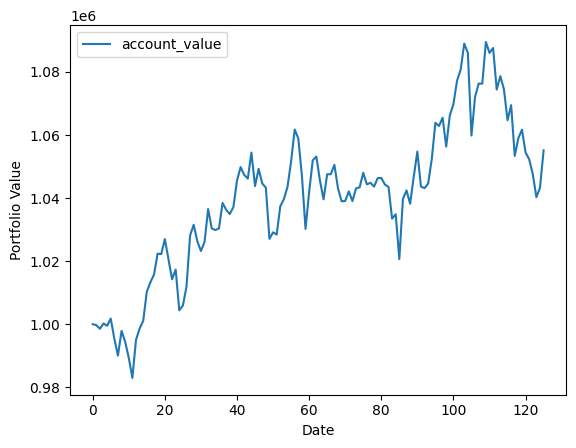

In [18]:
%matplotlib inline
import numpy as np
siz = len(df_account_value.account_value)
si = np.arange(1,siz,1)
print(si)
ax = df_account_value.plot(kind='line', y='account_value')
print(df_account_value.account_value.max)
# set the x-axis label
ax.set_xlabel('Date')
ax.set_ylabel('Portfolio Value')

# show the plot
plt.show()
df_account_value.account_value.plot()     


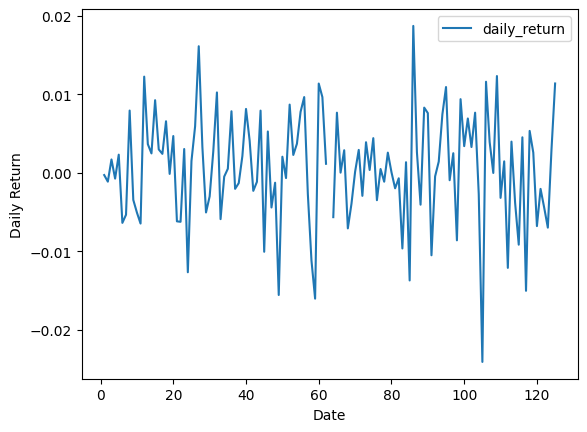

In [10]:
ax1 = df_account_value.plot(kind='line', y='daily_return')

# set the x-axis label
ax1.set_xlabel('Date')
ax1.set_ylabel('Daily Return')


# show the plot
plt.show()

In [11]:
!pip install git+https://github.com/quantopian/pyfolio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/quantopian/pyfolio to /tmp/pip-req-build-iujvmwv9
  Running command git clone --filter=blob:none --quiet https://github.com/quantopian/pyfolio /tmp/pip-req-build-iujvmwv9
  Resolved https://github.com/quantopian/pyfolio to commit 4b901f6d73aa02ceb6d04b7d83502e5c6f2e81aa
  Preparing metadata (setup.py) ... done


In [23]:
# import pyfolio
dji = pd.read_csv("/content/drive/MyDrive/robot learning final project/^DJI.csv")
# test_dji=dji[(dji['Date']>='2021-01-02') & (dji['Date']<='2021-09-30')]
# test_dji = test_dji.reset_index(drop=True)

,Date,Open,High,Low,Close,Adj Close,Volume
2923,2020-08-13,27922.509766,27986.099609,27789.779297,27896.720703,27896.720703,360160000
2924,2020-08-14,27828.929688,27977.810547,27759.390625,27931.019531,27931.019531,275540000
2925,2020-08-17,27970.050781,27999.810547,27816.400391,27844.910156,27844.910156,286860000
2926,2020-08-18,27853.480469,27891.119141,27668.789063,27778.070313,27778.070313,276170000
2927,2020-08-19,27811.259766,27920.419922,27647.669922,27692.880859,27692.880859,311460000


In [48]:
import yfinance as yf

# Define the ticker symbol and the date range
tickerSymbol = '^DJI'
startDate = '2021-01-02'
endDate = '2021-08-16'

# Download the data from Yahoo Finance
dji_df = yf.download(tickerSymbol, start=startDate, end=endDate)
dji_df['Date'] = dji_df.index
# Extract the Open, High, Low, and Close columns
# dji_ohlc = dji_df[['Date','Open', 'High', 'Low', 'Close']]
dji_df = pd.DataFrame(dji_df)
# Print the first few rows of the resulting DataFrame
print(dji_df.head())



[*********************100%***********************]  1 of 1 completed
                    Open          High           Low         Close  \
Date                                                                 
2021-01-04  30627.470703  30674.279297  29881.820312  30223.890625   
2021-01-05  30204.250000  30504.890625  30141.779297  30391.599609   
2021-01-06  30362.779297  31022.650391  30313.070312  30829.400391   
2021-01-07  30901.179688  31193.400391  30897.859375  31041.130859   
2021-01-08  31069.580078  31140.669922  30793.269531  31097.970703   

               Adj Close     Volume       Date  
Date                                            
2021-01-04  30223.890625  475080000 2021-01-04  
2021-01-05  30391.599609  350910000 2021-01-05  
2021-01-06  30829.400391  500430000 2021-01-06  
2021-01-07  31041.130859  427810000 2021-01-07  
2021-01-08  31097.970703  381150000 2021-01-08  


In [52]:
# dji_df.tail()
dji_df['Close_pct'] = dji_df['Close'] / dji_df['Close'].iloc[0]



In [63]:
df_account_value['account_value'] =df_account_value['account_value'] / df_account_value['account_value'].iloc[0]
df_account_value['account_value'].head()

0    1.000000
1    0.999700
2    0.998559
3    1.000243
4    0.999492
Name: account_value, dtype: float64

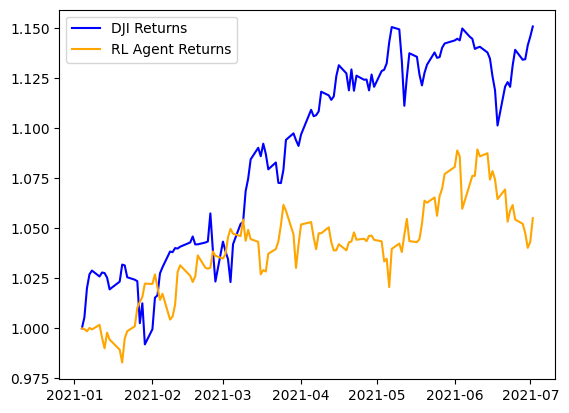

In [65]:
import matplotlib.pyplot as plt
# dji_df.Close_pct.plot()
y2 = df_account_value['account_value']
x = dji_df['Date'][:len(y2)]
y1 = dji_df['Close_pct'][:len(y2)]

plt.plot(x, y1, color='blue', label="DJI Returns")
plt.plot(x, y2, color='orange', label="RL Agent Returns", )
plt.legend(loc="upper left")
plt.show()



In [50]:
df_account_value.tail(30)

,account_value,date,daily_return,datadate
96,1.062845e+06,20210706,-0.000959,20210706
97,1.065482e+06,20210707,0.002481,20210707
98,1.056303e+06,20210708,-0.008614,20210708
99,1.066196e+06,20210709,0.009365,20210709
100,1.069801e+06,20210712,0.003382,20210712
101,1.077185e+06,20210713,0.006902,20210713
102,1.080704e+06,20210714,0.003267,20210714
103,1.088964e+06,20210715,0.007643,20210715
104,1.085999e+06,20210716,-0.002723,20210716
105,1.059826e+06,20210719,-0.024101,20210719


In [ ]:
def backtest_strat(df):
    strategy_ret= df.copy()
    strategy_ret['Date'] = pd.to_datetime(strategy_ret['Date'])
    strategy_ret.set_index('Date', drop = False, inplace = True)
    strategy_ret.index = strategy_ret.index.tz_localize('UTC')
    del strategy_ret['Date']
    ts = pd.Series(strategy_ret['daily_return'].values, index=strategy_ret.index)
    return ts
    
ensemble_strat = backtest_strat(df_account_value[0:1097])

<Axes: >

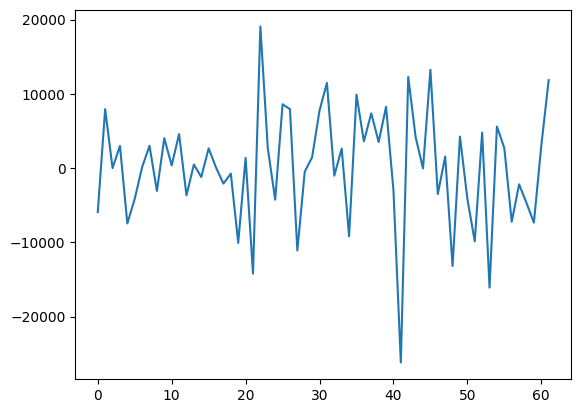

In [16]:
reward = pd.read_csv("/content/drive/MyDrive/robot learning final project/results/account_rewards_trade_ensemble_156.csv")

reward.account_rewards.plot()




<Axes: >

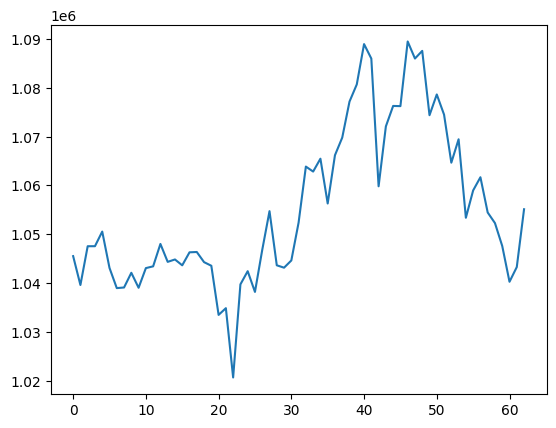

In [18]:
account_value = pd.read_csv("/content/drive/MyDrive/robot learning final project/results/account_value_trade_ensemble_156.csv")

account_value.account_value.plot()



In [20]:
action_trade = pd.read_csv("/content/drive/MyDrive/robot learning final project/results/actions_trade_ensemble_156.csv")

action_trade.head(30)

,date,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
0,20210518,79,61,-8,0,-100,81,-100,-80,100,...,-100,0,100,100,-12,24,21,29,-44,-22
1,20210519,28,0,100,100,-31,0,-100,0,97,...,1,0,100,-100,100,70,100,100,-100,-75
2,20210520,100,76,-25,-100,-6,39,-36,-31,-91,...,1,0,-100,100,-27,96,100,0,-100,0
3,20210521,0,85,-100,0,0,0,100,-93,-100,...,-62,0,-100,-100,-47,100,100,100,83,10
4,20210524,-38,0,0,0,1,-100,-24,-31,-20,...,-100,0,-100,-15,0,62,0,100,1,0
5,20210525,-64,-100,0,0,100,0,-100,0,0,...,-13,0,-76,0,1,0,70,-62,-9,0
6,20210526,-100,0,100,0,100,-39,2,0,0,...,0,0,0,0,0,0,72,-55,0,100
7,20210527,100,-51,-100,0,-19,0,-58,-100,17,...,0,0,0,0,-27,0,0,-62,-85,1
8,20210528,0,0,-100,0,-80,-3,-67,-100,0,...,0,0,0,0,0,92,0,0,1,100
9,20210601,1,0,0,0,100,-52,0,-75,1,...,0,100,0,0,0,75,-87,-23,100,0


In [76]:
account_reward = pd.read_csv("/content/drive/MyDrive/robot learning final project/results/account_rewards_trade_ensemble_156.csv")
account_reward1 = pd.read_csv("/content/drive/MyDrive/robot learning final project/results/account_rewards_trade_ensemble_93.csv")



,account_rewards,date
0,-5919.762653,20210518
1,7946.197156,20210519
2,6.629407,20210520
3,2996.001968,20210521
4,-7451.511550,20210524


In [94]:
# account_reward = account_reward.merge(account_reward1, how='inner', on=['account_rewards' ,'date'])
account_rewards = pd.concat([account_reward, account_reward1])


In [95]:
account_rewards.tail()

,account_rewards,date,account_rewards,date
57,-11849.148237,20210510,-11849.148237,20210510
58,-16796.539705,20210511,-16796.539705,20210511
59,11694.328862,20210512,11694.328862,20210512
60,10032.143376,20210513,10032.143376,20210513
61,1195.034496,20210514,1195.034496,20210514


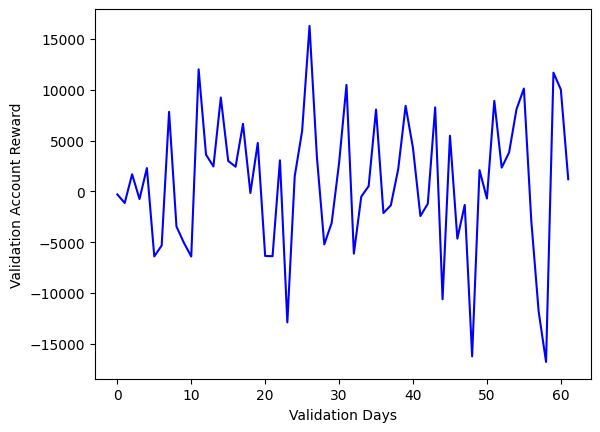

In [97]:
# account_reward.account_rewards.plot()
y11 = account_reward['account_rewards']

fig, ax1 = plt.subplots()
plt.plot(y11, color='blue')
ax1.set_ylabel("Validation Account Reward")
ax1.set_xlabel("Validation Days")

# plt.plot(x, y2, color='orange', label="RL Agent Returns", )
# plt.legend(loc="upper left")
plt.show()
